## 2 [indicateur](#section_2) 
## 3 [prédiction](#section_3) 
## 4 [évaluation](#section_4) 
## 5 [bot](#section_5) 

In [1]:
import pandas as pd
from binance.client import Client
import ta
import pandas_ta as pda
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
import seaborn as sns
import time

In [2]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

# ----- Functions Definition -------
def get_chop(high, low, close, window):
    tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(window).max()
    lowl = low.rolling(window).min()
    ci = 100 * np.log10((atr.rolling(window).sum()) / (highh - lowl)) / np.log10(window)
    return ci

In [3]:
bitcoin= pd.read_csv('./Data/BTC-EUR.csv',index_col='Date',parse_dates=True)
bitcoin

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-18,9253.401367,9316.917969,9240.340820,9246.486328,9246.486328,1.466026e+10
2019-09-19,9248.524414,9319.454102,8917.574219,9292.973633,9292.973633,1.804724e+10
2019-09-20,9292.886719,9334.069336,9194.604492,9239.483398,9239.483398,1.337076e+10
2019-09-21,9241.304688,9245.341797,9075.292969,9092.541992,9092.541992,1.218296e+10
2019-09-22,9096.534180,9142.628906,9004.768555,9138.951172,9138.951172,1.197878e+10
...,...,...,...,...,...,...
2021-10-22,53539.585938,54746.941406,51720.335938,52123.003906,52123.003906,3.300750e+10
2021-10-23,52125.031250,53026.136719,51379.496094,52734.601563,52734.601563,2.309100e+10
2021-10-24,52712.890625,52830.964844,51231.187500,52347.996094,52347.996094,2.346837e+10


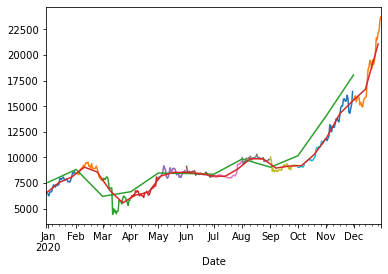

In [4]:
bitcoin['Close']['2020'].resample('M').plot();
bitcoin['Close']['2020'].resample('M').mean().plot()
bitcoin['Close']['2020'].resample('2W').mean().plot();

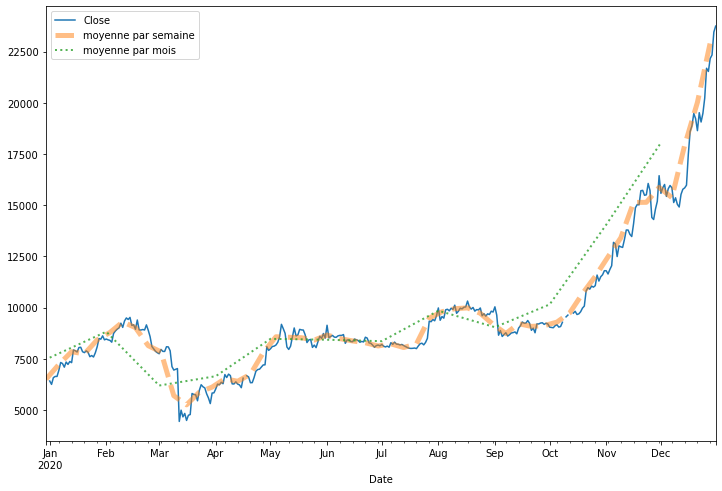

In [5]:
plt.figure(figsize=(12,8))
bitcoin['Close']['2020'].plot()
bitcoin['Close']['2020'].resample('W').mean().plot(label='moyenne par semaine',lw=5,ls='--',alpha=0.5)
bitcoin['Close']['2020'].resample('M').mean().plot(label='moyenne par mois',lw=2,ls=':',alpha=0.8)
plt.legend();

# Rolling

(770, 6)


,mean,std,min,max
Date,,,,
2020-01-05,6506.759375,168.691930,6252.938477,6640.674316
2020-01-12,7223.390276,155.490263,6939.714844,7369.640137
2020-01-19,7848.336984,252.597230,7313.747070,8063.265625
2020-01-26,7737.987932,118.117323,7589.612793,7889.409180
2020-02-02,8425.291225,163.802258,8085.500488,8621.291016


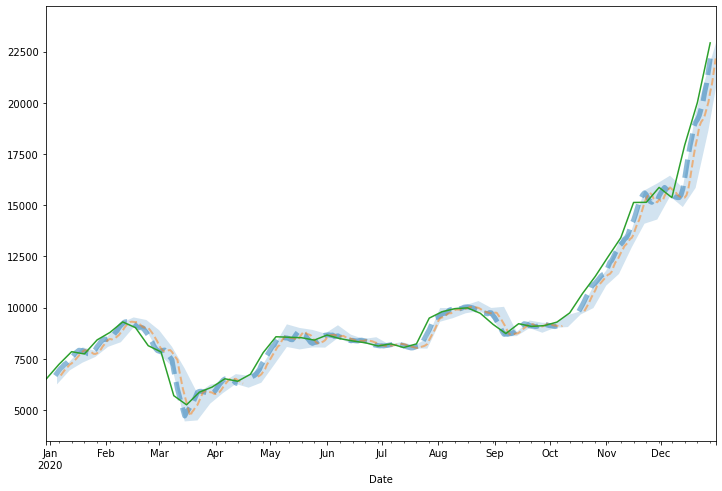

In [6]:
m=bitcoin['Close']['2020'].resample('W').agg(['mean','std','min','max'])

plt.figure(figsize=(12,8))
bitcoin['Close']['2020'].rolling(window=7,center=True).mean().plot(label='moyenne par semaine',lw=5,ls='--',alpha=0.5)
bitcoin['Close']['2020'].rolling(window=7,center=False).mean().plot(label='moyenne par semaine',lw=2,ls='--',alpha=0.5)
m['mean'].plot(label='moyenne de la semaine')
plt.fill_between(m.index,m['max'],m['min'],alpha=0.2,label='min-max par semaine')

print(bitcoin.shape)
bitcoin['Close']['2020'].resample('W').agg(['mean','std','min','max']).head()

<AxesSubplot:xlabel='Date'>

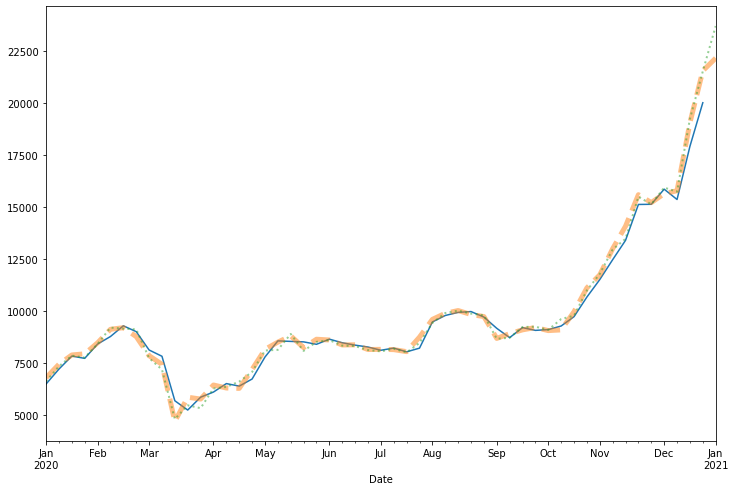

In [7]:
plt.figure(figsize=(12,8))
m['mean']['2020'].plot(label='moyenne de la semaine')
bitcoin['Close']['2020'].rolling(window=7,center=True).mean().plot(label='moyenne par semaine',lw=5,ls='--',alpha=0.5)
bitcoin['Close']['2020'].ewm(alpha=0.9).mean().plot(label='moyenne par semaine',lw=2,ls=':',alpha=0.5)


# <a class="anchor" id="section_2"></a> indicateur

In [8]:
data=bitcoin.copy()
#valeur à prédire
def plus_3(data):
    from scipy.special import cbrt #racine cubique 3
    data['day3']=np.nan
    for i, date in enumerate(data[:-3].index) :
        data['day3'][i] = cbrt((data.iloc[i+3]['Close']/data.iloc[i]['Close']-1)*100)
    return data
def plus_x(data,x=3):
    from scipy.special import cbrt #racine cubique 3
    data['day3']=np.nan
    for i, date in enumerate(data[:-x].index) :
        data['day3'][i] = cbrt((data.iloc[i+x]['Close']/data.iloc[i]['Close']-1)*100)
    return data
data=plus_3(data)

#indicateur
def indicator(data):
    data['VarianceHigh']  = (data['High']-data['Close'])
    data['VarianceLow']   = (data['Close']-data['Low'])
    data['RollingMax']    = data['Close'].shift(1).rolling(window=28).max()
    data['RollingMin']    = data['Close'].shift(1).rolling(window=28).min()
    data['SMA']=ta.trend.sma_indicator(data['Close'], window=12)

    #Relative Strength Index (RSI)
    data['RSI'] =ta.momentum.rsi(close=data['Close'], window=14)

    # #Average True Range (ATR) trop de NAN
    #data['ATR'] = ta.volatility.average_true_range(high=data['High'], low=data['Low'], close=data['Close'], window=14)

    # #Stochastic RSI
    data['STOCH_RSI'] = ta.momentum.stochrsi(close=data['Close'], window=14, smooth1=3, smooth2=3) #Non moyenné 
    data['STOCH_RSI_D'] = ta.momentum.stochrsi_d(close=data['Close'], window=14, smooth1=3, smooth2=3) #Orange sur TradingView
    data['STOCH_RSI_K'] =ta.momentum.stochrsi_k(close=data['Close'], window=14, smooth1=3, smooth2=3) #Bleu sur TradingView

    # #Choppiness index
    data['CHOP'] = get_chop(high=data['High'], low=data['Low'], close=data['Close'], window=14)  
    
    
    return data
indicator(data)

,Open,High,Low,Close,Adj Close,Volume,day3,VarianceHigh,VarianceLow,RollingMax,RollingMin,SMA,RSI,STOCH_RSI,STOCH_RSI_D,STOCH_RSI_K,CHOP
Date,,,,,,,,,,,,,,,,,
2019-09-18,9253.401367,9316.917969,9240.340820,9246.486328,9246.486328,1.466026e+10,-1.185211,70.431641,6.145508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-19,9248.524414,9319.454102,8917.574219,9292.973633,9292.973633,1.804724e+10,-1.183431,26.480469,375.399414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-20,9292.886719,9334.069336,9194.604492,9239.483398,9239.483398,1.337076e+10,-1.615015,94.585938,44.878906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-21,9241.304688,9245.341797,9075.292969,9092.541992,9092.541992,1.218296e+10,-2.405481,152.799805,17.249023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-22,9096.534180,9142.628906,9004.768555,9138.951172,9138.951172,1.197878e+10,-2.477816,3.677734,134.182617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,53539.585938,54746.941406,51720.335938,52123.003906,52123.003906,3.300750e+10,1.611284,2623.937500,402.667968,56634.0625,35113.835938,52242.068034,61.086482,0.000000,0.653714,0.333333,45.076653
2021-10-23,52125.031250,53026.136719,51379.496094,52734.601563,52734.601563,2.309100e+10,1.176169,291.535156,1355.105469,56634.0625,35113.835938,52490.288086,62.386431,0.073292,0.341477,0.024431,46.890266
2021-10-24,52712.890625,52830.964844,51231.187500,52347.996094,52347.996094,2.346837e+10,NaN,482.968750,1116.808594,56634.0625,35113.835938,52802.463867,60.999238,0.000000,0.127398,0.024431,47.250845


In [9]:
data['CHOP'].isna().sum()

46

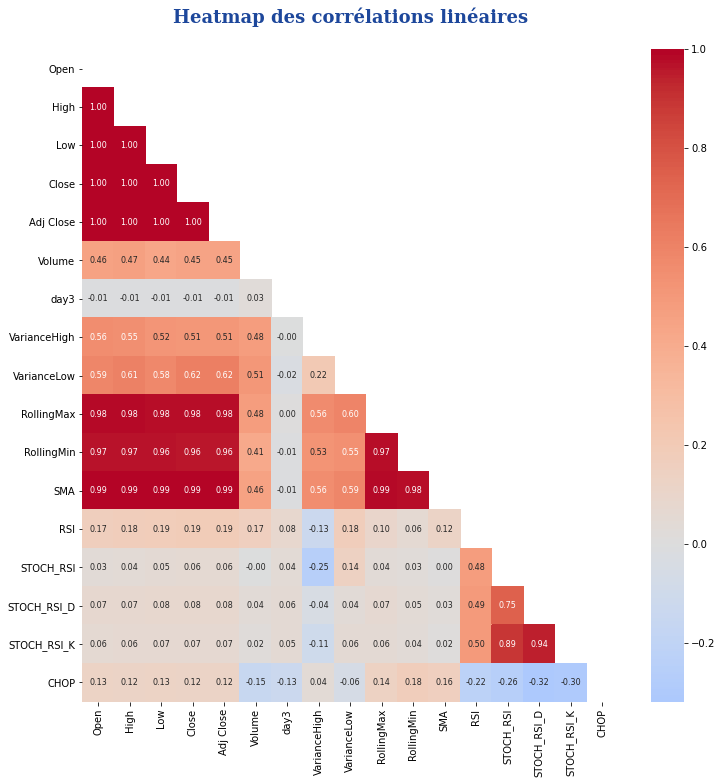

In [10]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontdict=font_title);


In [11]:
data_t=data[28:].drop(['Open','Adj Close'],axis=1).copy()
data_t=data_t.dropna(axis=0)
data_t

,High,Low,Close,Volume,day3,VarianceHigh,VarianceLow,RollingMax,RollingMin,SMA,RSI,STOCH_RSI,STOCH_RSI_D,STOCH_RSI_K,CHOP
Date,,,,,,,,,,,,,,,
2019-10-18,7286.020508,7074.515137,7138.117676,1.401229e+10,1.527006,147.902832,63.602539,9239.483398,7266.731445,7500.346476,28.490892,0.444136,0.592715,0.511988,47.174923
2019-10-19,7236.079102,7112.665039,7151.862793,1.235268e+10,1.144302,84.216309,39.197754,9138.951172,7138.117676,7470.084107,29.175343,0.470951,0.530898,0.492321,47.067634
2019-10-20,7423.996094,7126.044434,7370.443848,1.389833e+10,-2.033971,53.552246,244.399414,9138.951172,7138.117676,7458.591675,39.149855,0.751225,0.519915,0.555437,48.542047
2019-10-21,7439.778320,7349.857910,7392.276855,1.422976e+10,-2.057272,47.501465,42.418945,8850.279297,7138.117676,7422.608521,40.057936,0.815225,0.575631,0.679133,44.837913
2019-10-22,7455.320801,7255.664063,7259.024902,1.509941e+10,1.972763,196.295899,3.360839,7826.957031,7138.117676,7377.675049,36.479775,0.563042,0.648134,0.709831,45.747740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-19,55387.925781,52881.781250,55238.773438,3.478851e+10,-1.780084,149.152343,2356.992188,53408.671875,34712.968750,50512.179362,76.945152,1.000000,0.900842,0.923102,41.047926
2021-10-20,57457.261719,54619.558594,56634.062500,3.500447e+10,-1.902431,823.199219,2014.503906,55238.773438,35113.835938,51344.295248,78.823158,1.000000,0.918176,0.961143,41.002765
2021-10-21,57214.132813,53432.027344,53515.742188,3.949205e+10,-1.297047,3698.390625,83.714844,56634.062500,35113.835938,51844.918294,65.902672,0.000000,0.850304,0.666667,43.909197


In [12]:
from sklearn.model_selection import train_test_split

X = data_t.drop(['day3'], axis=1)
Y = data_t['day3'].values
    
X_train1, X_test, Y_train1, Y_test = train_test_split(X, Y, test_size=0.2, random_state=132)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.2, random_state=132)

print("Entrainement: {} lignes,\nValide: {} lignes,\nTest: {} lignes.".format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))


from sklearn.preprocessing import OneHotEncoder, StandardScaler
preprocessor=StandardScaler()
preprocessor.fit(X)

X_std  = preprocessor.transform(X)
X_train_std  = preprocessor.transform(X_train)
X_train1_std = preprocessor.transform(X_train1)
X_test_std   = preprocessor.transform(X_test)
X_valid_std  = preprocessor.transform(X_valid)
X_train_std.shape

Entrainement: 430 lignes,
Valide: 108 lignes,
Test: 135 lignes.


(430, 14)

In [13]:
np.array([X_train['Close']*X_train['CHOP']>=0]).mean()


1.0

# <a class="anchor" id="section_3"></a>prédiction

In [14]:
def custom_metric(y,y_pred) :   
    score=[]
    for i in range(0,len(y)) :
        if y[i]*y_pred[i]>=0 :
            return   1 + (abs(y[i])-abs(y_pred[i]-y[i]))
        else:
            return   -(abs(y_pred[i])+abs(y[i]))*2 
    return  np.array(score).mean()

In [15]:
# do metric
def custom_metric_lambda(y,y_pred) :
    if y*y_pred>=0 :
        return    (abs(y)-abs(y_pred-y))
    else:
        return   -(abs(y_pred)+abs(y))*2 

def custom_metric(y,y_pred) :
    df=pd.DataFrame(index=None,columns= ['y','y_pred'] )
    df['y']=y
    df['y_pred']=y_pred
    return  df.apply( lambda x : custom_metric_lambda(x['y'],x['y_pred']),axis=1).mean()

def custom_metric_2(y,y_pred) :
    return np.array([y*y_pred>=0]).mean()

In [16]:

     
            
from sklearn.metrics import make_scorer

custom_score = make_scorer(custom_metric , greater_is_better = True)
custom_score_2 = make_scorer(custom_metric_2 , greater_is_better = True)

Coefficient de détermination train  :  0.8219105494123546
Coefficient de détermination valid  :  0.15522270045763364
Coefficient de détermination test  :  0.012410180562429485
paramétre  :  {'ccp_alpha': 0.01}


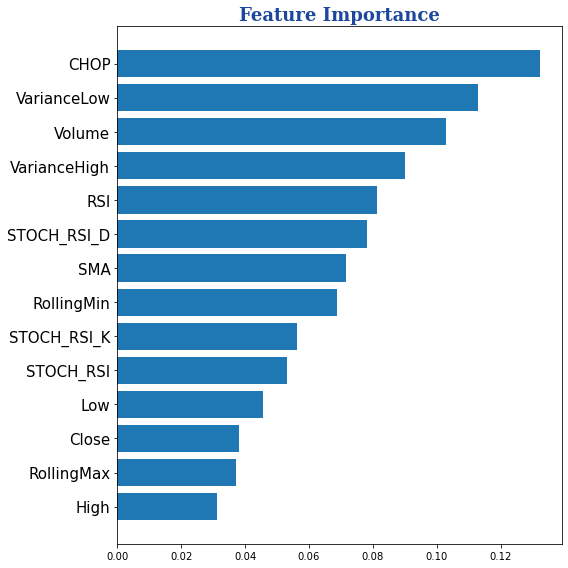

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

model = SVR(kernel='rbf',degree=3)
params = {'ccp_alpha'   :[1.e-2,1.e-3,1.e-4]}

grid = GridSearchCV(RandomForestRegressor( n_jobs=3,random_state=4),
                    param_grid=params,cv=5,scoring=custom_score_2)
grid.fit(X_train_std, Y_train)
#
best=grid.best_estimator_


print("Coefficient de détermination train  : " , best.score(X_train_std, Y_train))
print("Coefficient de détermination valid  : " , best.score(X_valid_std, Y_valid))
print("Coefficient de détermination test  : " , best.score(X_test_std, Y_test))

print("paramétre  : " , grid.best_params_)





# Get Feature importance data using feature_importances_ attribute
feature_importance = best.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx],size=15)
plt.title('Feature Importance',fontdict=font_title)

fig.tight_layout()
plt.show()

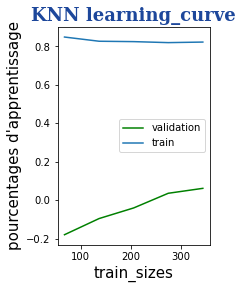

In [18]:
from sklearn.model_selection import learning_curve

N,train_score,val_score=learning_curve(best, X_train_std,Y_train,train_sizes=np.linspace(0.2,1,5),cv=5)

plt.subplot(1,2,2)
plt.plot(N,val_score.mean(axis=1),'g',label='validation')
plt.plot(N,train_score.mean(axis=1),label='train');
plt.ylabel("pourcentages d'apprentissage",fontsize=15) 
plt.xlabel("train_sizes" ,fontsize=15)  
plt.title("KNN learning_curve", fontdict=font_title)
plt.legend();

In [19]:
data_t['day3_predict']=best.predict(X_std)

data_t['buy']=np.zeros(len(data_t))
data_t['sell']=np.zeros(len(data_t))

data_t.loc[data_t['day3_predict'] >1,'buy'] = 1
data_t.loc[data_t['day3_predict'] < -1,'sell'] = 1    
data_t.shape

(673, 18)

# <a class="anchor" id="section_4"></a> évaluation

In [20]:
data_t=data_t.loc[X_valid.index.union(X_test.index).values,:]

data_t.shape

(243, 18)

In [21]:

def evaluation(data_t):
    frais=0.007
    btc=0.0
    usdt=1000
    lastindex=data_t.first_valid_index()

    for index,row in data_t.iterrows():
        if  data_t['buy'][index] and usdt>10:
            btc =usdt/data_t['Close'][index]
            btc = btc - (frais*btc)
            usdt=0
            print(f"{btc:.8} btc                                         ",index)

        if data_t['sell'][index] and btc > 0.0001:
            usdt =btc*data_t['Close'][index]
            usdt = usdt -(0.007*usdt)
            btc=0
            print(f"                      {usdt:.8} $                     ",index)
        lastindex=index

    return usdt +btc*data_t['Close'].iloc[-1]
evaluation(data_t)

0.1516832 btc                                          2019-12-18 00:00:00
                      5773.269 $                      2021-02-08 00:00:00
0.14506652 btc                                          2021-02-15 00:00:00
                      6993.1121 $                      2021-03-18 00:00:00
0.23836672 btc                                          2021-07-24 00:00:00
                      12568.575 $                      2021-10-15 00:00:00


12568.574911791604

In [22]:
X_valid.index.union(X_test.index) 

DatetimeIndex(['2019-10-19', '2019-10-21', '2019-10-23', '2019-10-26',
               '2019-10-27', '2019-10-29', '2019-11-01', '2019-11-02',
               '2019-11-04', '2019-11-10',
               ...
               '2021-09-22', '2021-09-24', '2021-10-04', '2021-10-05',
               '2021-10-08', '2021-10-13', '2021-10-15', '2021-10-19',
               '2021-10-20', '2021-10-22'],
              dtype='datetime64[ns]', name='Date', length=243, freq=None)

In [23]:
import seaborn as sns 

0.13884495 btc                                          2019-10-19 00:00:00
                      1019.1956 $                      2019-10-21 00:00:00
0.14992946 btc                                          2019-10-23 00:00:00
                      1234.5655 $                      2019-11-01 00:00:00
0.18087977 btc                                          2019-11-28 00:00:00
                      1513.5218 $                      2020-02-02 00:00:00
0.16676418 btc                                          2020-02-08 00:00:00
                      1032.0194 $                      2020-04-03 00:00:00
0.11986596 btc                                          2020-06-06 00:00:00
                      999.53825 $                      2020-06-18 00:00:00
0.11989394 btc                                          2020-06-24 00:00:00
                      1194.5996 $                      2020-08-16 00:00:00
0.13656271 btc                                          2020-09-06 00:00:00
                  

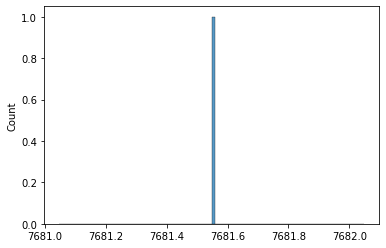

In [24]:
data_t=data[28:-3].drop(['Open','Adj Close'],axis=1).copy()
data_t=data_t.dropna(axis=0)

X = data_t.drop(['day3'], axis=1)
Y = data_t['day3'].values
resultat=[]  
params = {'ccp_alpha'   :[1.e-2,1.e-3,1.e-4,1.e-5]}    
    
for i in range(0,1):    
    X_train1, X_test, Y_train1, Y_test = train_test_split(X, Y, test_size=0.2, random_state=132)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.2, random_state=132)


    preprocessor=StandardScaler()
    preprocessor.fit(X)

    X_std  = preprocessor.transform(X)
    X_train_std  = preprocessor.transform(X_train)
    X_test_std   = preprocessor.transform(X_test)
    X_valid_std  = preprocessor.transform(X_valid)


    grid = GridSearchCV(RandomForestRegressor(n_jobs=3),
                        param_grid=params,cv=5,scoring=custom_score)
    grid.fit(X_train_std, Y_train)
    #
    best=grid.best_estimator_
    data_t['day3_predict']=best.predict(X_std)

    data_t['buy']=np.zeros(len(data_t))
    data_t['sell']=np.zeros(len(data_t))
    data_t.loc[data_t['day3_predict'] >0.4,'buy'] = 1
    data_t.loc[data_t['day3_predict'] < -0.4,'sell'] = 1    
    data_r=data_t.loc[X_valid.index.union(X_test.index).values,:]

    resultat.append(evaluation(data_r))
    print(f"resultat = {resultat[i]}")
sns.histplot(resultat, bins=100);

7681.547556690807

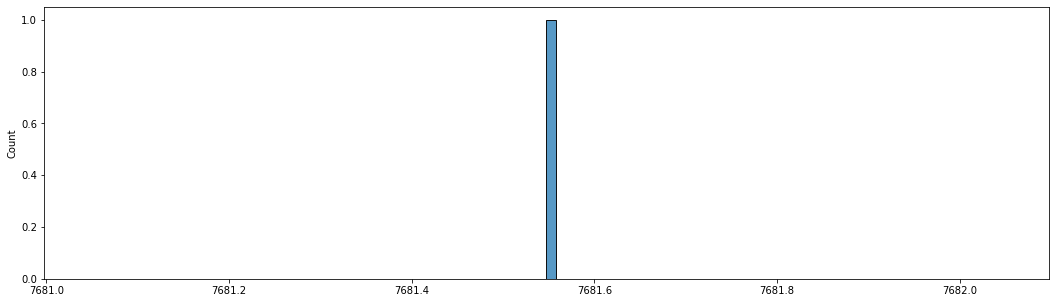

In [25]:
fig = plt.figure(figsize=(18, 5))
sns.histplot(resultat, bins=100);
np.array(resultat).mean()

In [26]:
X_std.shape

(673, 14)

#  Validation HEure par heure

In [27]:
def getBalance(myclient, coin):
    jsonBalance = myclient.get_balances()
    pandaBalance = pd.DataFrame(jsonBalance)
    if pandaBalance.loc[pandaBalance['coin'] == coin].empty : return 0
    else : return float(pandaBalance.loc[pandaBalance['coin'] == coin]['free'])

def truncate(n, decimals=0):
    r = floor(float(n)*10**decimals)/10**decimals
    return str(r)

#valeur à prédire
def plus_3(data):
    from scipy.special import cbrt #racine cubique 3
    data['day3']=np.nan
    for i, date in enumerate(data[:-3].index) :
        data['day3'][i] = cbrt((data.iloc[i+3]['close']/data.iloc[i]['close']-1)*100)
    return data
def plus_x(data,x=3):
    from scipy.special import cbrt #racine cubique 3
    data['plus_x']=np.nan
    for i, date in enumerate(data[:-x].index) :
        data['plus_x'][i] = cbrt((data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100)
    return data


#indicateur
def indicator(data):
    data['VarianceHigh']  = (data['high']-data['close'])
    data['VarianceLow']   = (data['close']-data['low'])
    data['RollingMax']    = data['close'].shift(1).rolling(window=28).max()
    data['RollingMin']    = data['close'].shift(1).rolling(window=28).min()
    data['SMA']=ta.trend.sma_indicator(data['close'], window=12)

    #Relative Strength Index (RSI)
    data['RSI'] =ta.momentum.rsi(close=data['close'], window=14)

    # #Average True Range (ATR) trop de NAN
    #data['ATR'] = ta.volatility.average_true_range(high=data['high'], low=data['low'], close=data['Close'], window=14)

    # #Stochastic RSI
    data['STOCH_RSI'] = ta.momentum.stochrsi(close=data['close'], window=14, smooth1=3, smooth2=3) #Non moyenné 
    data['STOCH_RSI_D'] = ta.momentum.stochrsi_d(close=data['close'], window=14, smooth1=3, smooth2=3) #Orange sur TradingView
    data['STOCH_RSI_K'] =ta.momentum.stochrsi_k(close=data['close'], window=14, smooth1=3, smooth2=3) #Bleu sur TradingView

    # #Choppiness index
    data['CHOP'] = get_chop(high=data['high'], low=data['low'], close=data['close'], window=14)  
    
    
    return data

def evaluation(data_t):
    frais=0.00067
    btc=0.0
    usdt=1000
    lastindex=data_t.first_valid_index()

    for index,row in data_t.iterrows():
        if  data_t['buy'][index] and usdt>10:
            btc =usdt/data_t['close'][index]
            btc = btc - (frais*btc)
            usdt=0
            print(f"{btc:.8} btc                                         ",index)

        if data_t['sell'][index] and btc > 0.0001:
            usdt =btc*data_t['close'][index]
            usdt = usdt -(0.007*usdt)
            btc=0
            print(f"                      {usdt:.8} $                     ",index)
        lastindex=index

    return usdt +btc*data_t['close'].iloc[-1]


In [28]:
#gestion des dichiers
import os
from pathlib import Path
import pickle
import wget 

if not Path( r'./Data/btcusdt_train.pkl').is_file() or 1:
    print('dl le fichier dans data en cours: ')
    os.makedirs('./Data/', exist_ok=True)
    client = Client()
    klinesT = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "01 january 2012")

    df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    df['close'] = pd.to_numeric(df['close'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['open'] = pd.to_numeric(df['open'])

    df = df.set_index(df['timestamp'])
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.drop( ['timestamp','open',
                   'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'],axis=1)

    df.to_pickle(r'./Data/btcusdt_train.pkl')
else:
    df= pd.read_pickle(r'./Data/btcusdt_train.pkl')
    

df=plus_x(df,17)
df=indicator(df)    
df.head(3)

dl le fichier dans data en cours: 


C:\Users\polo1\AppData\Local\Temp\ipykernel_20308\1969172682.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['plus_x'][i] = cbrt((data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100)


,high,low,close,volume,plus_x,VarianceHigh,VarianceLow,RollingMax,RollingMin,SMA,RSI,STOCH_RSI,STOCH_RSI_D,STOCH_RSI_K,CHOP
timestamp,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4313.62,4261.32,4308.83,47.18100900,0.830927,4.79,47.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4328.69,4291.37,4315.32,23.23491600,0.792514,13.37,23.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,4345.45,4309.37,4324.35,7.22969100,-0.968382,21.10,14.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(41282, 15)
test (8257, 18)
0.017081344 btc                                          2021-04-09 12:00:00
                      71.367343 $                      2017-09-27 21:00:00
0.01356666 btc                                          2019-04-22 08:00:00
                      245.08366 $                      2020-12-10 11:00:00
0.036466751 btc                                          2018-06-18 21:00:00
                      299.26148 $                      2018-07-26 19:00:00
0.043594894 btc                                          2018-04-07 10:00:00
                      424.02983 $                      2020-02-24 12:00:00
0.056970462 btc                                          2019-10-25 01:00:00
                      2658.5771 $                      2021-12-31 02:00:00
0.35692447 btc                                          2018-07-22 08:00:00
                      3011.6711 $                      2019-11-15 18:00:00
0.5677777 btc                                          2020-03

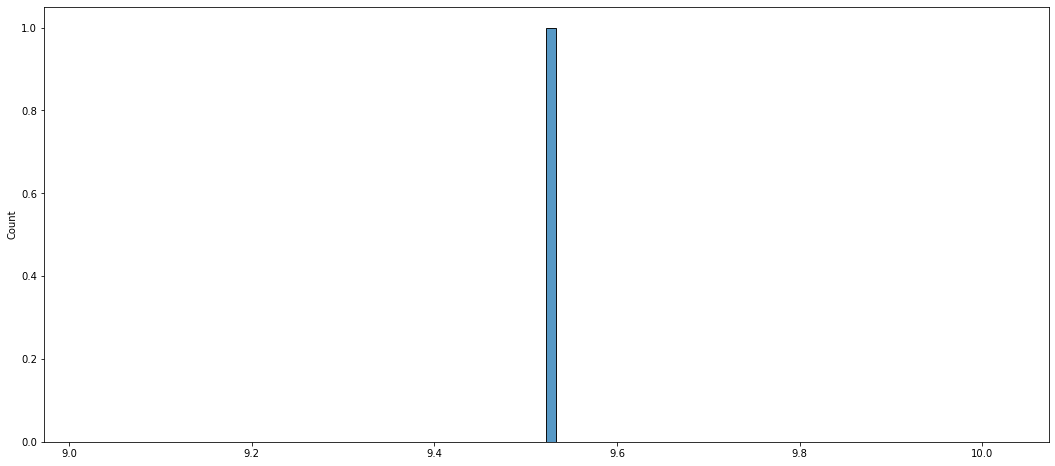

In [29]:

data_t=df.dropna(axis=0).copy()
print(data_t.shape)
X = data_t.drop(['plus_x'], axis=1)
Y = data_t['plus_x'].values
resultat=[]  
  


for i in range(0,1):    
    X_train1, X_test, Y_train1, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.2, random_state=12)


    preprocessor=StandardScaler().fit(X)
    
    X_std  = preprocessor.transform(X)
    X_train_std  = preprocessor.transform(X_train)
    X_test_std   = preprocessor.transform(X_test)
    X_valid_std  = preprocessor.transform(X_valid)


    best = RandomForestRegressor(n_jobs=-2).fit(X_std, Y)
  
   
    data_t['predict']=best.predict(X_std)

    data_t['buy']=np.zeros(len(data_t))
    data_t['sell']=np.zeros(len(data_t))
    data_t.loc[data_t['predict'] >0.4,'buy'] = 1
    data_t.loc[data_t['predict'] < -0.4,'sell'] = 1    
    data_r=data_t.loc[X_test.index,:]
    print(f"test {data_r.shape}")
    resultat.append(evaluation(data_r))
    print(f"resultat = {resultat[i]:.7}     score train = {best.score(X_train_std, Y_train):.7} score valid  :  {best.score(X_valid_std, Y_valid):.7}\n")
fig = plt.figure(figsize=(18, 8))
sns.histplot(resultat, bins=100);

from sklearn.model_selection import learning_curve

N,train_score,val_score=learning_curve(best, X_train_std,Y_train,train_sizes=np.linspace(0.2,1,5),cv=5)


plt.plot(N,val_score.mean(axis=1),'g',label='validation')
plt.plot(N,train_score.mean(axis=1),label='train');
plt.ylabel("pourcentages d'apprentissage",fontsize=15) 
plt.xlabel("train_sizes" ,fontsize=15)  
plt.title("KNN learning_curve", fontdict=font_title)
plt.legend();

In [12]:
!pip install pyyaml

## <a class="anchor" id="section_5"></a> Bot

pip install ftx
pip install ciso8601
pip install python-binance


In [25]:
import yaml
BOT_CONFIG_FILE = 'env/auth.yaml'

with open(BOT_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)
    

import json

subaccount_name=config['FTX']['subaccount_name']
api_key=config['FTX']['api_key']
api_secret=config['FTX']['api_secret']


C:\Users\polo1\AppData\Local\Temp\ipykernel_6696\1115139103.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(config_file)


In [26]:
subaccount_name

'btcbot'

In [27]:
import ftx
#from ftx import FtxClient
import pandas as pd
import ta
import time
import json
from math import *

accountName = 'btcbot'
pairSymbol = 'BTC/USDT'
fiatSymbol = 'USDT'
cryptoSymbol = 'BTC'
myTruncate = 4

client = ftx.FtxClient( api_key=api_key,
                        api_secret=api_secret,
                        subaccount_name=subaccount_name)

data = client.get_historical_data(
    market_name=pairSymbol, 
    resolution=3600, 
    limit=650, 
    start_time=float(
    round(time.time()))-650*3600, 
    end_time=float(round(time.time())))

    
df = pd.DataFrame(data)
df = df.set_index(df['startTime'])
df.index = pd.to_datetime(df.index)
df = df.drop( ['time','startTime','open'],axis=1)
df=indicator(df).dropna(axis=0) 
df.iloc[-4:]

NameError: name 'indicator' is not defined

In [ ]:
max=0
trigger = True
while trigger == True:
    try:

        #chargement
        data = client.get_historical_data(
            market_name=pairSymbol, 
            resolution=3600, 
            limit=650, 
            start_time=float(
            round(time.time()))-650*3600, 
            end_time=float(round(time.time())))  
        df = pd.DataFrame(data)
        df = df.set_index(df['startTime'])
        df.index = pd.to_datetime(df.index)
        df = df.drop( ['time','startTime','open'],axis=1)


        #prediction
        df = indicator(df).dropna(axis=0) 
        X_unique  = preprocessor.transform(df)
        predict=best.predict(X_unique)[-1]

        if abs(max) < abs(predict) : max=predict

        #achat/vente
        actualPrice = df['close'].iloc[-1]
        fiatAmount = getBalance(client, fiatSymbol)
        cryptoAmount = getBalance(client, cryptoSymbol)
        print(f"pred {predict:.3}  actualPrice {actualPrice:.5} fiatAmount {fiatAmount:.3} cryptoAmount {cryptoAmount:.4}")

        if float(fiatAmount) > 10 and       predict > 0.4  :
            quantityBuy = truncate(float(fiatAmount)/actualPrice, myTruncate)
            buyOrder = client.place_order(
                market=pairSymbol, 
                side="buy", 
                price=None, 
                size=quantityBuy, 
                type='market')
            print("\n    buyOrder" ,buyOrder)

        if float(cryptoAmount) > 0.0002 and  predict < -0.4:
            buyOrder = client.place_order(
                market=pairSymbol, 
                side="sell", 
                price=None, 
                size=truncate(cryptoAmount, myTruncate), 
                type='market')
            print("\n    buyOrder" ,buyOrder)

        
        time.sleep((65-time.gmtime(time.time()).tm_sec))
        
    
    except  KeyboardInterrupt:
        trigger = False
print(f" max = {max}")


print('shutdown complete')

NameError: name 'client' is not defined

In [ ]:
sma 200 pour une long tandence

In [ ]:

dt = None #resultat isoler
dt = pd.DataFrame(columns = ['date','position', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 1000
initalWallet = usdt
coin = 0
wallet = 1000
lastAth = 0
lastIndex = df.first_valid_index()
fee = 0.0007

for index, row in dfTest.iterrows():
  #Buy
  if row['EMA28'] > row['EMA48'] and row['STOCH_RSI'] < 0.8 and  usdt > 0:
    coin = usdt / row['close']
    frais = fee * coin
    coin = coin - frais
    usdt = 0
    wallet = coin * row['close']
    if wallet > lastAth:
        lastAth = wallet
    # print("Buy COIN at",df['close'][index],'$ the', index)
    myrow = {'date': index,'position': "Buy",'price': row['close'],'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)

  #Sell
  if row['EMA28'] < row['EMA48'] and row['STOCH_RSI'] > 0.2 and coin > 0:
    usdt = coin * row['close']
    frais = fee * usdt
    usdt = usdt - frais
    coin = 0
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at",df['close'][index],'$ the', index)
    myrow = {'date': index,'position': "Sell",'price': row['close'],'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  lastIndex = index

#///////////////////////////////////////
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 1000 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")

dt[['wallet','price']].plot(subplots=True, figsize=(12,10))
print('PLOT')